# DF CON VARIABLES DE 4 HORAS #

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error


In [5]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']


In [95]:
def get_binance_ohlcv(symbol, interval="1h", days=250):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume"]]

In [96]:
df=get_binance_ohlcv("BTCUSDT")

In [30]:
monedas=[]
for i in symbols:
    if (i[4:]=='USDT' or i[3:]=='USDT'):
        monedas.append(i)
        
len(monedas)

444

In [8]:
df=pd.read_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/data/raw/BTCUSDT_1h_3years.csv")

In [97]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100

porcentaje(df,"close",1,"1hora%")
porcentaje(df,"close",4,"4hora%")
porcentaje(df,"close",8,"8hora%")
porcentaje(df,"close",24,"dia%")
porcentaje(df,"close",48,"2dias%")
porcentaje(df,"close",24*7,"1semana%")
porcentaje(df,"close",24*7*2,"2semanas%")
porcentaje(df,"close",24*7*4,"1mes%")
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [98]:
df_porcentual=df

In [99]:
df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [100]:

def calcular_RSI(df, column="close", period=14):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2025-02-19 23:00:00,96539.84,96899.99,96522.55,96644.37,544.26596,-0.108266,-0.455094,-0.730251,-1.016632,-0.902454,1.252294,-0.033060,6.809871,-1.718289,NaN
1,2025-02-20 00:00:00,96644.37,96853.99,96415.09,96853.98,361.82303,-0.216888,-0.699995,-0.575265,-1.598476,-1.271514,0.986445,-0.027905,6.246913,-1.427241,100.000000
2,2025-02-20 01:00:00,96853.98,97000.00,96627.09,96767.67,564.83079,0.089114,-0.469321,-0.392262,-1.348639,-0.520878,1.243563,0.403470,5.988685,-1.595915,94.042553
3,2025-02-20 02:00:00,96767.67,97275.54,96739.48,97134.52,975.14038,-0.379104,-0.615984,-1.530231,-1.359424,-1.113887,0.347930,0.235775,5.378015,-1.005410,95.389579
4,2025-02-20 03:00:00,97134.52,97362.83,96979.29,97055.25,821.46063,0.081608,-0.425146,-0.882175,-1.405273,-0.889033,0.454541,0.308580,5.276141,-1.119713,90.299002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,2025-09-29 18:00:00,114043.92,114137.73,113867.02,114008.79,396.89151,0.030795,0.021695,-1.711666,-3.368492,-4.179496,-1.405027,1.126550,-4.365425,NaN,78.813524
5324,2025-09-29 19:00:00,114008.78,114390.93,113848.63,114265.55,747.93438,-0.225211,-0.395359,-1.931802,-3.559938,-4.424387,-1.910983,0.903868,-4.621882,NaN,81.425403
5325,2025-09-29 20:00:00,114265.56,114400.00,114122.12,114258.29,497.44944,0.006354,-0.556333,-1.996150,-3.117664,-4.450398,-1.309084,0.972179,-4.942174,NaN,81.099215
5326,2025-09-29 21:00:00,114258.29,114329.80,114095.36,114176.73,218.26557,0.071382,-0.116464,-0.838526,-3.015988,-4.294807,-1.068195,1.169647,-5.914548,NaN,77.095828


In [101]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 100,200]):

    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
0,2025-02-19 23:00:00,96539.84,96899.99,96522.55,96644.37,544.26596,-0.108266,-0.455094,-0.730251,-1.016632,...,1.252294,-0.033060,6.809871,-1.718289,NaN,96644.370000,96644.370000,96644.370000,96644.370000,96644.370000
1,2025-02-20 00:00:00,96644.37,96853.99,96415.09,96853.98,361.82303,-0.216888,-0.699995,-0.575265,-1.598476,...,0.986445,-0.027905,6.246913,-1.427241,100.000000,96686.292000,96663.425455,96652.590000,96648.520693,96646.455672
2,2025-02-20 01:00:00,96853.98,97000.00,96627.09,96767.67,564.83079,0.089114,-0.469321,-0.392262,-1.348639,...,1.243563,0.403470,5.988685,-1.595915,94.042553,96702.567600,96672.902231,96657.102941,96650.880085,96647.661784
3,2025-02-20 02:00:00,96767.67,97275.54,96739.48,97134.52,975.14038,-0.379104,-0.615984,-1.530231,-1.359424,...,0.347930,0.235775,5.378015,-1.005410,95.389579,96788.958080,96714.867483,96675.825179,96660.457113,96652.506145
4,2025-02-20 03:00:00,97134.52,97362.83,96979.29,97055.25,821.46063,0.081608,-0.425146,-0.882175,-1.405273,...,0.454541,0.308580,5.276141,-1.119713,90.299002,96842.216464,96745.811348,96690.704584,96668.274794,96656.513546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,2025-09-29 18:00:00,114043.92,114137.73,113867.02,114008.79,396.89151,0.030795,0.021695,-1.711666,-3.368492,...,-1.405027,1.126550,-4.365425,NaN,78.813524,113354.216386,112503.113737,111430.617978,111100.495807,111714.716074
5324,2025-09-29 19:00:00,114008.78,114390.93,113848.63,114265.55,747.93438,-0.225211,-0.395359,-1.931802,-3.559938,...,-1.910983,0.903868,-4.621882,NaN,81.425403,113536.483109,112663.335215,111541.791783,111163.170147,111740.097506
5325,2025-09-29 20:00:00,114265.56,114400.00,114122.12,114258.29,497.44944,0.006354,-0.556333,-1.996150,-3.117664,...,-1.309084,0.972179,-4.942174,NaN,81.099215,113680.844487,112808.331105,111648.321125,111224.459649,111765.154148
5326,2025-09-29 21:00:00,114258.29,114329.80,114095.36,114176.73,218.26557,0.071382,-0.116464,-0.838526,-3.015988,...,-1.068195,1.169647,-5.914548,NaN,77.095828,113780.021590,112932.731004,111747.474414,111282.920448,111789.149927


In [110]:
df_porcentual.head(26)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia
0,2025-02-20 00:00:00,96644.37,96853.99,96415.09,96853.98,361.82303,-0.216888,-0.699995,-0.575265,-1.598476,...,-0.027905,6.246913,-1.427241,100.000000,96686.292000,96663.425455,96652.590000,96648.520693,96646.455672,0
1,2025-02-20 01:00:00,96853.98,97000.00,96627.09,96767.67,564.83079,0.089114,-0.469321,-0.392262,-1.348639,...,0.403470,5.988685,-1.595915,94.042553,96702.567600,96672.902231,96657.102941,96650.880085,96647.661784,0
2,2025-02-20 02:00:00,96767.67,97275.54,96739.48,97134.52,975.14038,-0.379104,-0.615984,-1.530231,-1.359424,...,0.235775,5.378015,-1.005410,95.389579,96788.958080,96714.867483,96675.825179,96660.457113,96652.506145,0
3,2025-02-20 03:00:00,97134.52,97362.83,96979.29,97055.25,821.46063,0.081608,-0.425146,-0.882175,-1.405273,...,0.308580,5.276141,-1.119713,90.299002,96842.216464,96745.811348,96690.704584,96668.274794,96656.513546,0
4,2025-02-20 04:00:00,97055.24,97339.11,97034.59,97224.46,848.42996,-0.174344,-0.382514,-1.085186,-2.111678,...,0.402133,4.752143,-1.007514,91.425980,96918.665171,96789.324862,96711.636168,96679.288363,96662.164755,0
5,2025-02-20 05:00:00,97224.46,97224.46,96891.47,96909.99,667.47648,0.323447,-0.147074,-0.617086,-1.700778,...,0.941906,5.483655,-1.468982,73.192589,96916.930137,96800.294420,96719.414750,96683.856712,96664.630678,0
6,2025-02-20 06:00:00,96909.99,96999.30,96781.57,96907.99,494.40390,0.002064,0.233213,-0.381335,-1.350899,...,1.503147,5.230669,-1.549924,73.085627,96915.142110,96810.084927,96726.809858,96688.294995,96667.052163,0
7,2025-02-20 07:00:00,96908.00,97088.87,96804.00,96867.92,330.86128,0.041348,0.193014,-0.231312,-1.233398,...,1.352087,5.688185,-1.354256,70.697259,96905.697688,96815.342661,96732.343589,96691.851926,96669.050848,0
8,2025-02-20 08:00:00,96867.92,97197.74,96801.61,97150.01,395.65532,-0.291211,0.076575,-0.305646,-1.589480,...,0.997081,4.955929,-1.094596,76.844046,96954.560150,96845.766965,96748.722664,96700.924363,96673.836512,0
9,2025-02-20 09:00:00,97150.01,97284.00,97150.00,97184.63,437.65289,-0.035636,-0.283397,-0.430888,-1.300046,...,1.449869,4.413584,-1.186474,77.512047,97000.574120,96876.572695,96765.817069,96710.502692,96678.919034,0


In [102]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=160):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [16]:
resistencias

,price_level,volume
0,16663.879156,8.501500e+06
1,22750.034094,4.028141e+06
2,23426.273531,3.797033e+06
3,20721.315781,3.701144e+06
4,17340.118594,3.239064e+06
...,...,...
155,120804.752531,1.321623e+04
156,32893.625656,8.931360e+03
157,122833.470844,8.142569e+03
158,123509.710281,4.100259e+03


In [103]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [104]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [105]:
len(df_porcentual)

5303

In [107]:
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:5202+i]
    outsider=df_porcentual[5202+i+1:5202+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=RandomForestRegressor( n_estimators=50, random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [108]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 0.3242138542155277
n_aciertos: 0.8
error total: 0.3775597162243621


error_aciertos: 0.4229796776854819
n_aciertos: 0.7407407407407407
error total: 0.3972226355496451

error_aciertos: 12.440987291914553
n_aciertos: 0.8888888888888888
error total: 11.108442476204964

error_aciertos: 13.969168697452707
n_aciertos: 0.8888888888888888
error total: 12.49051817763226

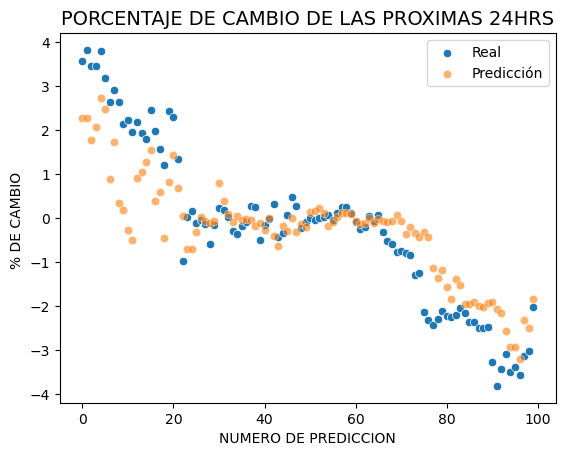

In [123]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
plt.title("PORCENTAJE DE CAMBIO DE LAS PROXIMAS 24HRS", fontsize=14)
plt.ylabel("% DE CAMBIO ")
plt.xlabel("NUMERO DE PREDICCION")

sns.scatterplot(guardados,x=guardados.index,y=guardados["real"],label="Real")
sns.scatterplot(guardados,x=guardados.index,y="predicciones",label="Predicción",alpha=0.6)
plt.legend()

In [68]:
guardados

,real,predicciones,dif
0,-0.530370,-0.661569,NaN
1,-0.339771,0.194919,NaN
2,-0.016941,0.193793,NaN
3,-0.411103,0.026306,NaN
4,-0.461263,0.038172,NaN
5,0.071854,0.151440,NaN
6,-0.261552,-0.115646,NaN
7,-0.158726,-0.061214,NaN
8,0.003538,-0.237282,NaN
9,-0.259786,0.291672,NaN


In [25]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


108652.05649918457
108623.84035025992
108565.617978208
108556.61915596946
108688.21073022288
109213.56485095747
109385.47936513659
109269.53359773687
108546.74588996585
108354.1146542709


In [26]:
comparacion

,real,prediccion
0,109541.36,108652.056499
1,109411.20,108623.840350
2,109252.01,108565.617978
3,109292.73,108556.619156
4,109431.70,108688.210730
5,109310.21,109213.564851
6,109400.05,109385.479365
7,109306.61,109269.533598
8,109287.89,108546.745890
9,109402.24,108354.114654


In [ ]:
#crear DF completo y modelo  guardarlo todo para mañana 

import requests
import pandas as pd
import time
import joblib

cripto=[]
accuracy=[]
error_acertados=[]
e_total=[]
contador=0



binance_coins = [
    "ETHUSDT",  # Ethereum
    "BTCUSDT",  # Bitcoin  
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
]
# guardar en CSV
for simbolo in binance_coins:
    print(simbolo)
    df=get_binance_ohlcv(simbolo)
    
    porcentaje(df,"close",1,"1hora%")
    porcentaje(df,"close",4,"4hora%")
    porcentaje(df,"close",8,"8hora%")
    porcentaje(df,"close",24,"dia%")
    porcentaje(df,"close",48,"2dias%")
    porcentaje(df,"close",24*7,"1semana%")
    porcentaje(df,"close",24*7*2,"2semanas%")
    porcentaje(df,"close",24*7*4,"1mes%")
    


    df_porcentual=df
    calcular_RSI(df_porcentual)
    agregar_emas(df_porcentual)

    resistencias=volumen_por_precio(df_porcentual)
    df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)
    #df.dropna(inplace=True)
    #df.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    resis=[]
    df_porcentual["resistencia"]=0
    lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
    lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
    lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
    for i in list(round(resistencias["price_level"],0)):
        if i in lista_redondeada_high:

            indice=lista_redondeada_high.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_low:

            indice=lista_redondeada_low.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_close:

            indice=lista_redondeada_close.index(i)
            df_porcentual.loc[indice,"resistencia"]=1


    df_porcentual.dropna(inplace=True)
    df_porcentual.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    df_porcentual.to_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/data/raw/df_cripto/"+str(simbolo)+"_1h_250days_porcentual.csv", index=False)
    print("se tuvo que guardar")
    relativ_error=[]
    aciertos_direccion_list=[]
    error_aciertos_list=[]
    y_pred_guardadas=[]
    y_real_guardadas=[]
    restricciones=["open_time","pred_dia%"]
    medir="pred_dia%"
    print("empieza a modelo n: "+str(contador))
    filas=len(df_porcentual["close"])
    for i in range(120):
        if i%10==0:
            print(i)
        #vamos a separar los datos de entreno y los outsider
        entreno=df_porcentual[0+i:5183+i]
        outsider=df_porcentual[5183+i+1:5183+i+2]
        #print(outsider)
        outsider.reset_index(drop=True,inplace=True)
        entreno.reset_index(drop=True,inplace=True)
        #ahora ponemos el y el x
        X_entreno=entreno.drop(restricciones,axis=1)
        y=entreno[medir]
        X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
        model=RandomForestRegressor( n_estimators=50, random_state=42)
        model.fit(X_train,y_train)
        X_outsider=outsider.drop(restricciones,axis=1)
        y_outsider=outsider[medir]#es el real
        predicciones_outsider=model.predict(X_outsider)
        #print(y_outsider[0])
        y_pred_guardadas.append(predicciones_outsider[0])
        y_real_guardadas.append(y_outsider[0])
        error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        relativ_error.append(error_relativo_porcentual)
        if y_outsider[0]*predicciones_outsider>0:
            aciertos_direccion_list.append(predicciones_outsider)
            error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
            error_aciertos_list.append(error_relativo_aciertos)

    error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
    aciertos_direccion=len(aciertos_direccion_list)
    error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)
    contador+=1
    
    cripto.append(simbolo)
    accuracy.append(aciertos_direccion/len(relativ_error))
    error_acertados.append(error_aciertos)
    e_total.append(error_total)
    print(accuracy)
    

# Supón que tu modelo se llama 'model'
    joblib.dump(model,"/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/models/rand_forest_rf_"+str(simbolo)+".pkl")

ETHUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 0
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333]
BTCUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 1
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667]
BNBUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 2
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.85]
XRPUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 3
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.85, 0.875]
SOLUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 4
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.85, 0.875, 0.8583333333333333]
DOGEUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 5
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.85, 0.875, 0.8583333333333333, 0.8]
ADAUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 6
0
10
20
30
40
50
60
70
80
90
100
110
[0.8

KeyError: 'dia%'

In [ ]:
binance_coins = [
    "ETHUSDT"
    ,"BTCUSDT",  # Bitcoin  # Ethereum
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "DOGEUSDT", # Dogecoin
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "MATICUSDT",# Polygon
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
    "TRXUSDT",  # Tron
    "ATOMUSDT", # Cosmos
    "SHIBUSDT", # Shiba Inu
    "WBTCUSDT", # Wrapped Bitcoin
    "BUSDUSDT", # Binance USD (stablecoin)
    "XLMUSDT"   # Stellar
]



# XGBoots #

In [76]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [77]:

relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:5200+i]
    outsider=df_porcentual[5200+i+1:5200+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=XGBRegressor(random_state=42,colsample_bytree=1.0, gamma= 0.5, learning_rate= 0.04 ,min_child_weight= 5, n_estimators= 500, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [78]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 0.1108909812506338
n_aciertos: 0.78
error total: 0.5004365038015522


<Axes: xlabel='None', ylabel='real'>

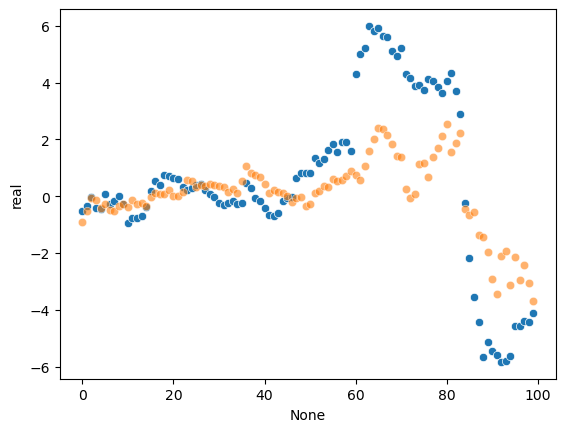

In [79]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [ ]:
def detectar_zonas_bajo_volumen(df, bins=80, n_zonas=150):
    """
    Calcula las zonas de bajo volumen (LVN) a partir de un perfil de volumen simple.

    bins: número de niveles de precios en el histograma
    n_zonas: cantidad de zonas de bajo volumen que quieres identificar
    """
    # Tomamos precio medio de cada vela
    df["precio_medio"] = (df["high"] + df["low"]) / 2
    precios = df["precio_medio"]
    volumenes = df["volume"]

    # Construir histograma ponderado por volumen
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Normalizamos
    hist = hist / hist.max()

    # Detectar los índices de menor volumen
    indices_lv = np.argsort(hist)[:n_zonas]
    zonas_bajo_volumen = [(edges[i], edges[i+1], hist[i]) for i in indices_lv]
   
    return zonas_bajo_volumen, hist, edges
zbv=detectar_zonas_bajo_volumen(df_porcentual)


In [ ]:
#zonas de bajo volumen
df_porcentual["bajo_volumen"]=0
for i in zbv[0]:
    down=list(df_porcentual["close"].round(-3)).index(round(float(i[0]),-3))
    up=list(df_porcentual["close"].round(-3)).index(round(float(i[1]),-3))
    for o in range(1000):
        if df_porcentual["close"][o]==o:
            break
        elif df_porcentual["close"][o]!=o:
            df_porcentual.loc[o,"bajo_volumen"]=1

            






In [ ]:
#agregar las zonas de bajo volumen
for i in zbv[0]:
    for o in i:
        print(o)

368.34175000000005
371.57087500000006
0.0
365.1126250000001
368.34175000000005
0.0
342.5087500000001
345.73787500000003
0.021427931892905067
339.279625
342.5087500000001
0.02576023878280346
355.42525000000006
358.6543750000001
0.03869081730676724
361.8835
365.1126250000001
0.04046366988838033
119.699125
122.92825
0.055616995295260756
336.05050000000006
339.279625
0.06277751075950701
371.57087500000006
374.8
0.06433110183897132
358.6543750000001
361.8835
0.07327003818001582
345.73787500000003
348.96700000000004
0.08829675771830653
352.19612500000005
355.42525000000006
0.08864454585151317
348.96700000000004
352.19612500000005
0.11393790044654274
116.47
119.699125
0.1258172223606787
332.82137500000005
336.05050000000006
0.12996095364524937
155.2195
158.448625
0.13675905731590166
122.92825
126.157375
0.1494916480194506
151.990375
155.2195
0.15606293327294016
126.157375
129.3865
0.17280733975357737
239.17675000000003
242.40587500000004
0.1926511798808756
145.532125
148.76125000000002
0.2184

In [ ]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']
